In [1]:
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import sys

In [2]:
box = 'Box000'
curr_run_fname = "/oak/stanford/orgs/kipac/aemulus/aemulus_alpha/" + box + "/";
rockstar_dir = curr_run_fname + "halos/m200b/"




10it [00:19,  1.91s/it]


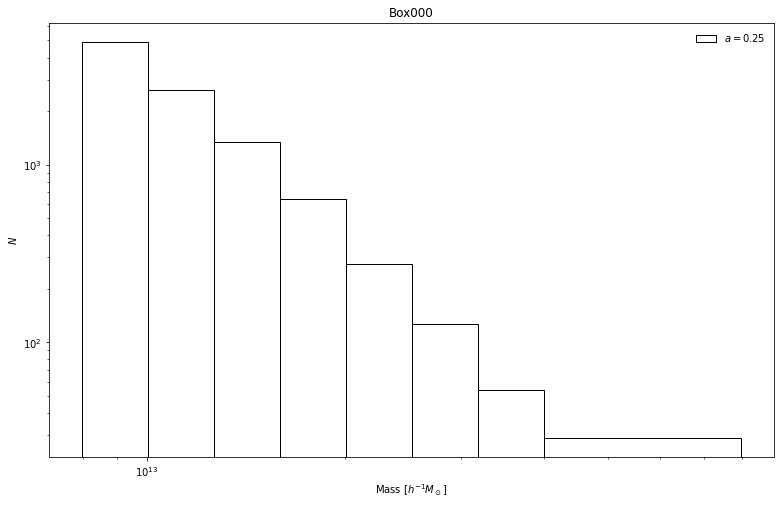

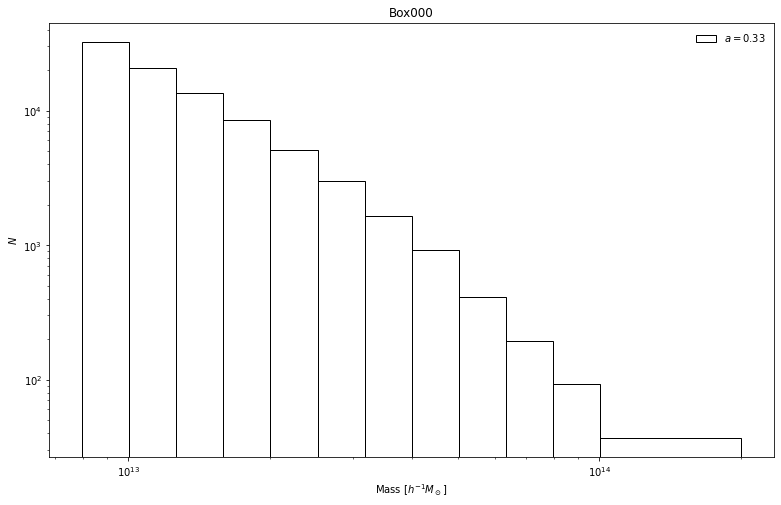

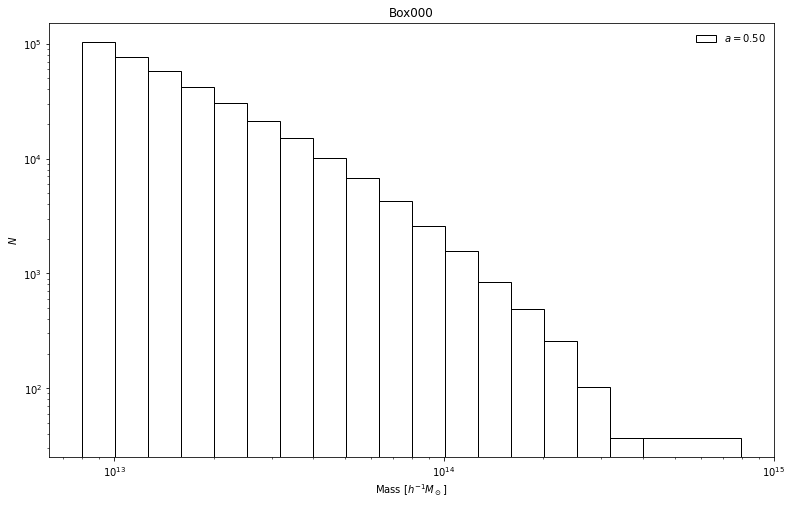

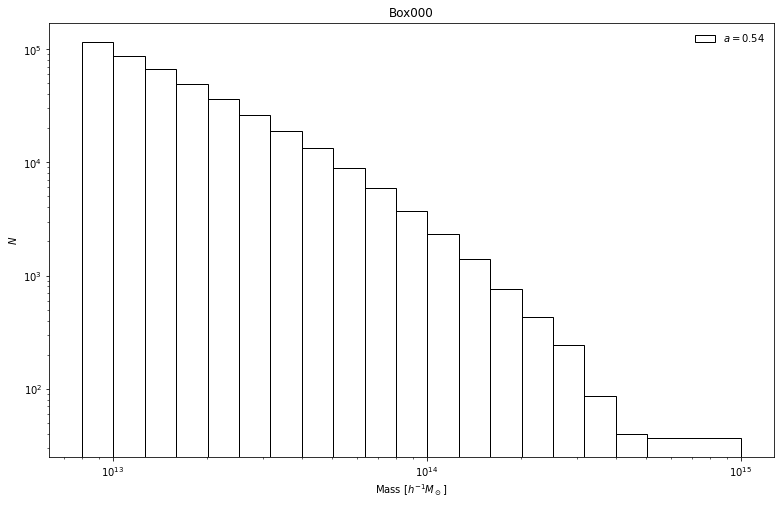

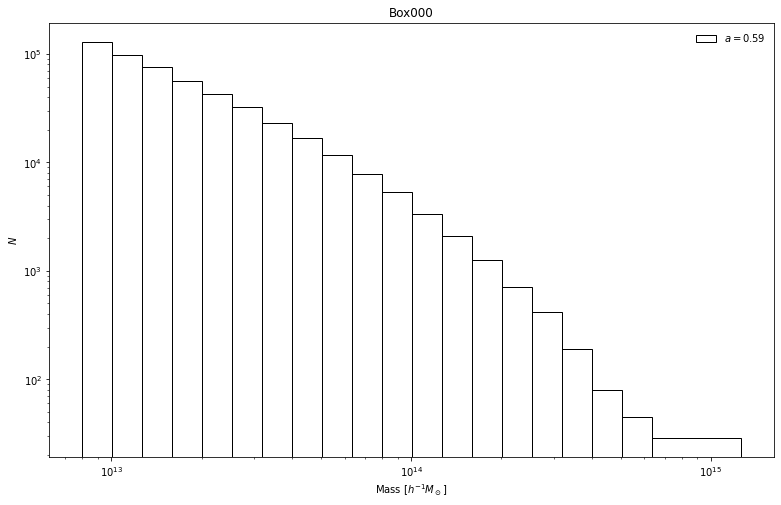

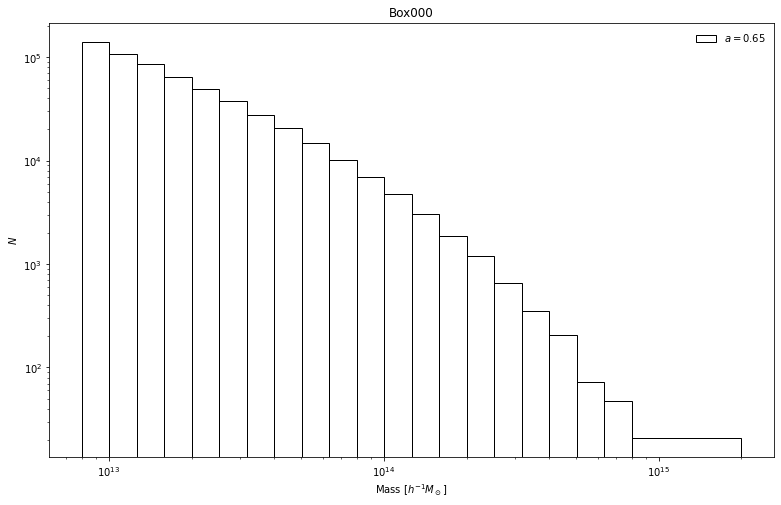

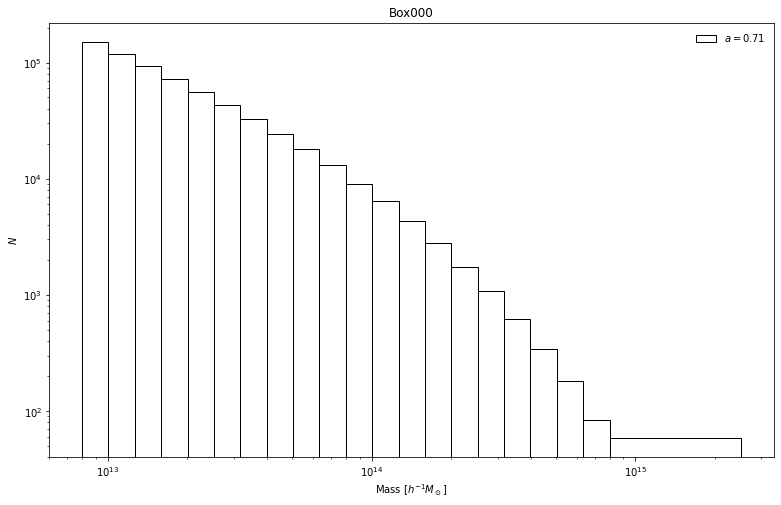

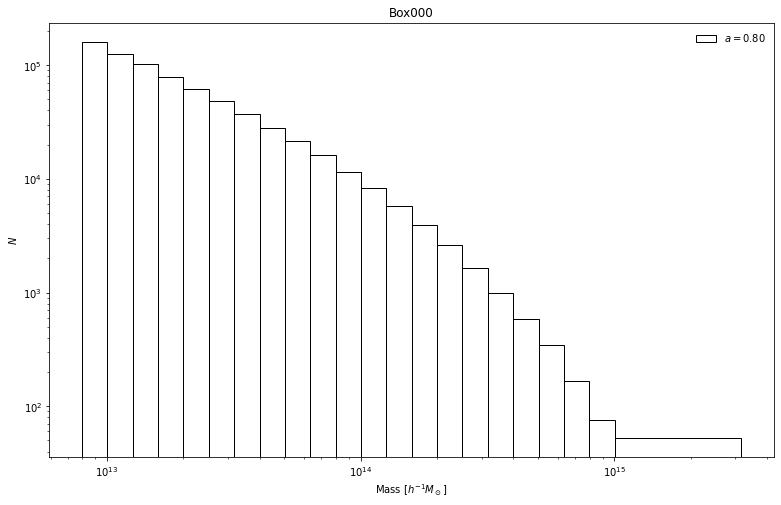

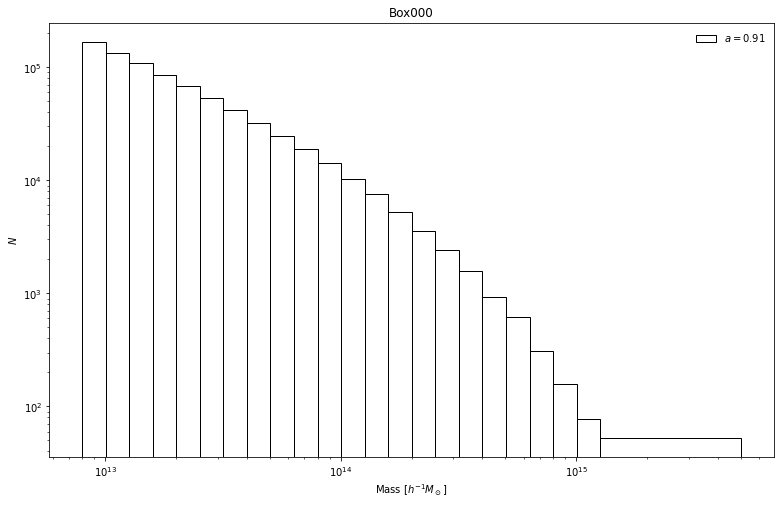

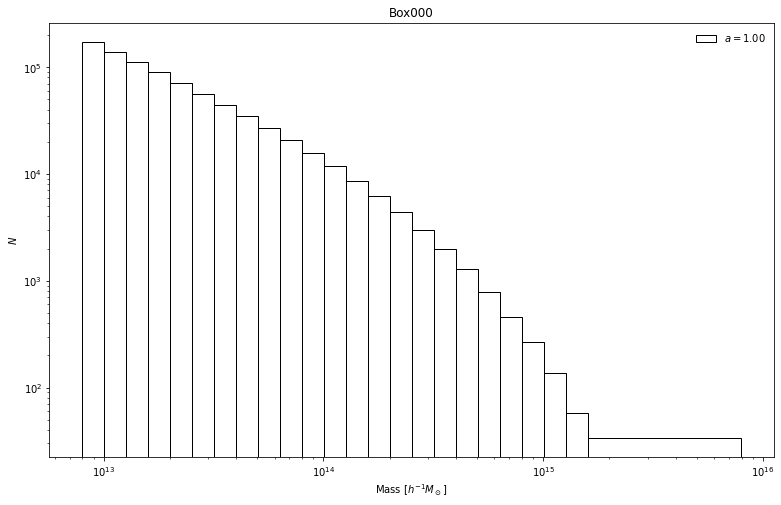

In [3]:
N_snapshots = 10

i=0

import pickle

NvMs = {}
f = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+box+'_M200b', 'r')

TMP=0
for line in tqdm(f):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))

    #extract the masses and position of halos for a given snapshot 
    snapshot_mass = line.strip().split()
    snapshot_mass = np.array(snapshot_mass, dtype=np.float64)  
    


    f = open(rockstar_dir+'out_%d.list'%(i), 'r')
    
    #get the volume, redshift, and particle mass in the simulation
    vol = -1
    BOX_SIZE = -1
    a = -1
    Mpart = -1
    for line in f:
        if('#a' in line):
            a = eval(line.split()[2])
        if('Particle mass' in line):
            Mpart = eval(line.split()[2])
        if('Box size' in line):
            vol = eval(line.split()[2])**3
            BOX_SIZE = eval(line.split()[2])
            break
            
    
    
    nBins = 16
    
    #we'll only consider halos with more than 200 particles
    edges_log10 = np.arange(np.log10(200*Mpart), 1+np.log10(np.max(snapshot_mass)), 0.1)
    edges = np.array([10**el10 for el10 in edges_log10])

    #get the number count of halos in the mass bins
    N, bin_edge, bin_idx = binned_statistic(snapshot_mass, np.ones_like(snapshot_mass), 
                                            statistic='count', bins=edges)
    c_i = len(N)-1
    while(N[c_i] == 0):
        N = N[:c_i]
        bin_edge = bin_edge[:(c_i+1)]
        c_i -= 1
#         print('---')
#         print(N)
#         print(bin_edge)
#         print('---')

        
    #make large mass bin have at least 20 halos
    while(N[c_i] < 20):
        N[c_i-1] += N[c_i]
        halos_here = np.where(bin_idx==c_i+1)
        bin_idx[halos_here] = c_i
        N = N[:c_i]
        bin_edge = np.delete(bin_edge,c_i)
        c_i -= 1
#         print('---')
#         print(N)
#         print(bin_edge)
#         print('---')

        
    M_means = []
    correction = np.zeros_like(N)
    
    for j in range(len(N)):
        this_bin = np.where(bin_idx == j+1)
        M_means += [np.mean(snapshot_mass[this_bin])]
#         print(N[j], len(snapshot_mass[this_bin]))
        assert(len(snapshot_mass[this_bin]) == N[j])
            
    edge_pairs = [[bin_edge[i], bin_edge[i+1]] for i in range(len(bin_edge)-1)]
    assert(len(edge_pairs) == len(N))
    ax.bar(x=bin_edge[:-1], height=N, width=np.diff(bin_edge), align='edge', fill=False, label=r'$a=%.2f$'%(a))

    ax.set_title(curr_run_fname.split('/')[-2])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    ax.set_ylabel(r'$N$')
    ax.legend(frameon=False)

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/'+curr_run_fname.split('/')[-2]+'_NvsM_a%.1f.pdf'%(a), bbox_inches='tight')

    i+=1
    assert(len(edge_pairs) == len(N))
    NvMs[a] = {'M':M_means, 
               'N':N, 
               'vol':vol, 
               'Mpart':Mpart, 
               'edge_pairs':edge_pairs,
               'bin_idx':bin_idx,
               'corrections':correction}
f.close()

In [4]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+curr_run_fname.split('/')[-2]+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'wb')
pickle.dump(NvMs, NvM_f)
NvM_f.close()

In [5]:
jackknife = {}
f_pos = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+box+'_pos', 'r')
for a in tqdm(NvMs):
    snapshot_pos  = f_pos.readline().strip().split(',')
    snapshot_pos  = [np.array(pos.split(), dtype=np.float32) for pos in snapshot_pos if pos != '']
    snapshot_pos  = np.array(snapshot_pos)

    N = NvMs[a]['N']
    vol = NvMs[a]['vol']
    bin_idx = NvMs[a]['bin_idx']
    correction = NvMs[a]['corrections']

    assert(len(bin_idx) == len(snapshot_pos))
    #now lets get to spatial jackknife
    N_DIVS = 4 #each axis is diided into N_DIVS parts so in total the box
               #is divided into N_DIVS**3 boxes

    #compute the size of each smaller cube
    ϵ = vol*10**(-6)
    cube_vol = (vol+ε) / N_DIVS**3 #need ϵ to properly handle halos directly on boundary 
    cube_size = np.cbrt(cube_vol)
    rescale_factor = N_DIVS**3/(N_DIVS**3-1)

    #compute the indices of the smaller cube that each point belongs to
    cube_indices = (snapshot_pos / cube_size).astype(int)

    #cube_indices has assignment of halo to 3d position of a voxel
    #ravel_multi_index indexes the voxels in 3D with a single integer
    cube_assignment = np.ravel_multi_index(cube_indices.T, (N_DIVS, N_DIVS, N_DIVS), order='F')

    jackknife_data = []

    for i in range(N_DIVS**3):
        current_cube = np.where(cube_assignment == i)
        curr_N = np.zeros_like(N)
        for halo in bin_idx[current_cube]:
            #bin_idx=1 corresponds to first bin 
            #bin_idx-1 = idx of bin
            if(halo==0):
                continue
            curr_N[halo-1] += 1
        #get the histogram if we left out this sub-cube
        jackknife_data += [[a-b for (a,b) in zip(N, curr_N)]]

    jackknife_mean = np.mean(jackknife_data, axis=0)

    jackknife_data = np.array(jackknife_data) - jackknife_mean
    jackknife_data *= rescale_factor
    jackknife_covariance = np.cov(jackknife_data.T)
    
    jackknife[a] = [jackknife_data, jackknife_covariance]
f_pos.close()

100%|██████████| 10/10 [02:36<00:00, 15.66s/it]


In [6]:
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+curr_run_fname.split('/')[-2]+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'wb')
pickle.dump(jackknife, jackknife_covs_f)
jackknife_covs_f.close()
